In [166]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer,r2_score
from scipy.stats import skew
from IPython.display import display
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [167]:
# Get train data
train = pd.read_csv("./Data/train.csv")
print("train : " + str(train.shape))

train : (1460, 81)


In [168]:
# Get test data
test = pd.read_csv("./Data/test.csv")
print("test:" + str(test.shape))

test:(1459, 80)


In [169]:
# Find data that is quantitative or qualitative
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

print(len(quantitative))
print(len(qualitative))


36
43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

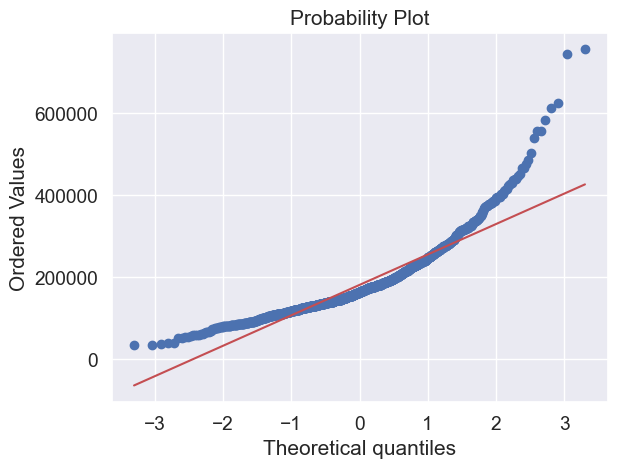

In [170]:
train.info()
train['SalePrice'].describe()
#sns.displot(train['SalePrice'],kde=True)
res=stats.probplot(train['SalePrice'],plot=plt,dist="norm")
plt.show()

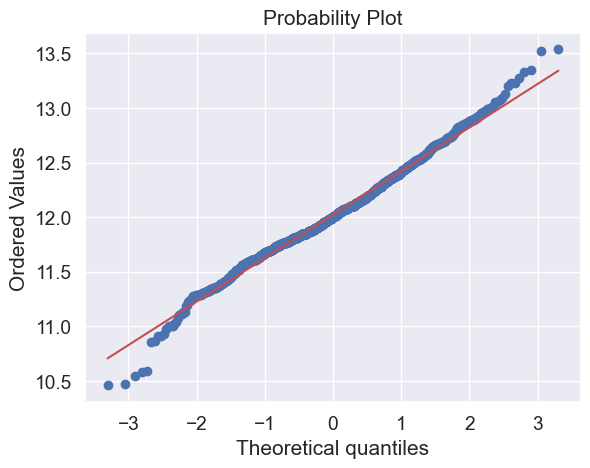

In [171]:
# Normalize SalePrice
train['SalePrice']=np.log(train['SalePrice'])
res=stats.probplot(train['SalePrice'],plot=plt,dist="norm")
plt.show()

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

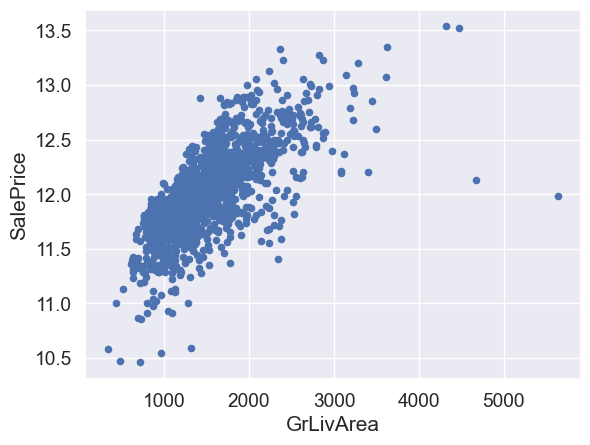

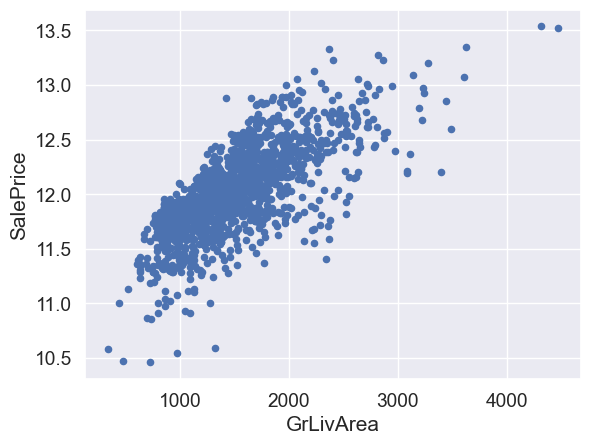

In [172]:
# Check Outliers
data=pd.concat([train['SalePrice'],train['GrLivArea']],axis=1)
data.plot.scatter(x='GrLivArea',y='SalePrice')

train.loc[(train['SalePrice']<12.5) & (train['GrLivArea']>4000)]
train.drop(523,axis=0,inplace=True)
train.drop(1298,axis=0,inplace=True)

# Sale Price vs. Gr Living area after outliers removed
data_mo=pd.concat([train['SalePrice'],train['GrLivArea']],axis=1)
data_mo.plot.scatter(x='GrLivArea',y='SalePrice')

In [173]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [174]:
# normalize quantitative variables
skewedset = all_data[quantitative].apply(lambda x: skew(x.dropna()))
skewedset = skewedset[skewedset > .75]
skewedset = skewedset.index

all_data[skewedset] = np.log1p(all_data[skewedset])

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

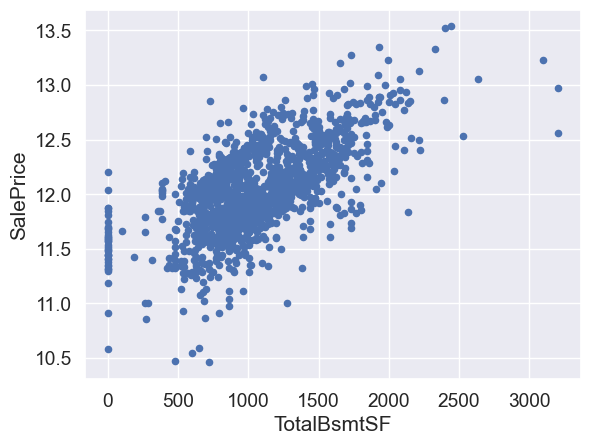

In [175]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice')

In [176]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

train=pd.concat([X_train,y],axis=1)

train.shape

(1458, 80)

C:\Users\xiaos\AppData\Local\Temp\ipykernel_5984\2355245665.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train.corr()


(37, 37)

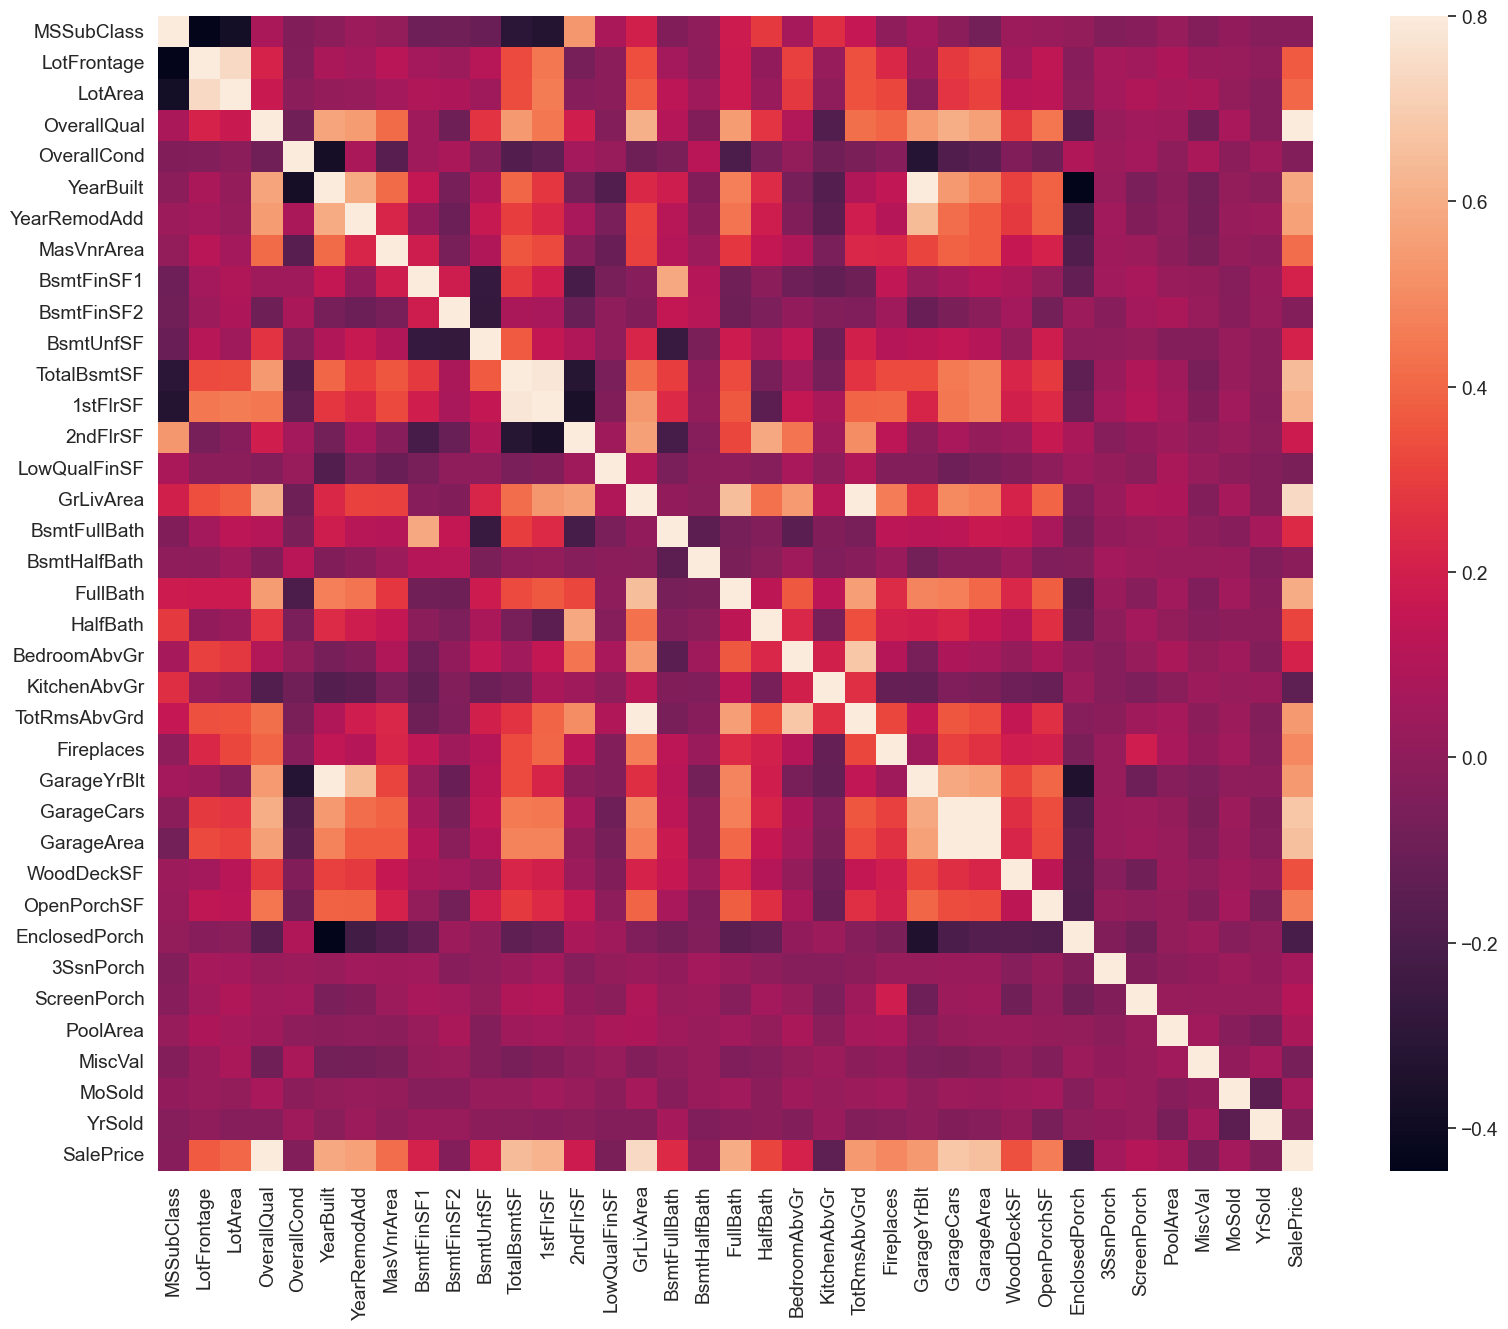

In [181]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True)

nan

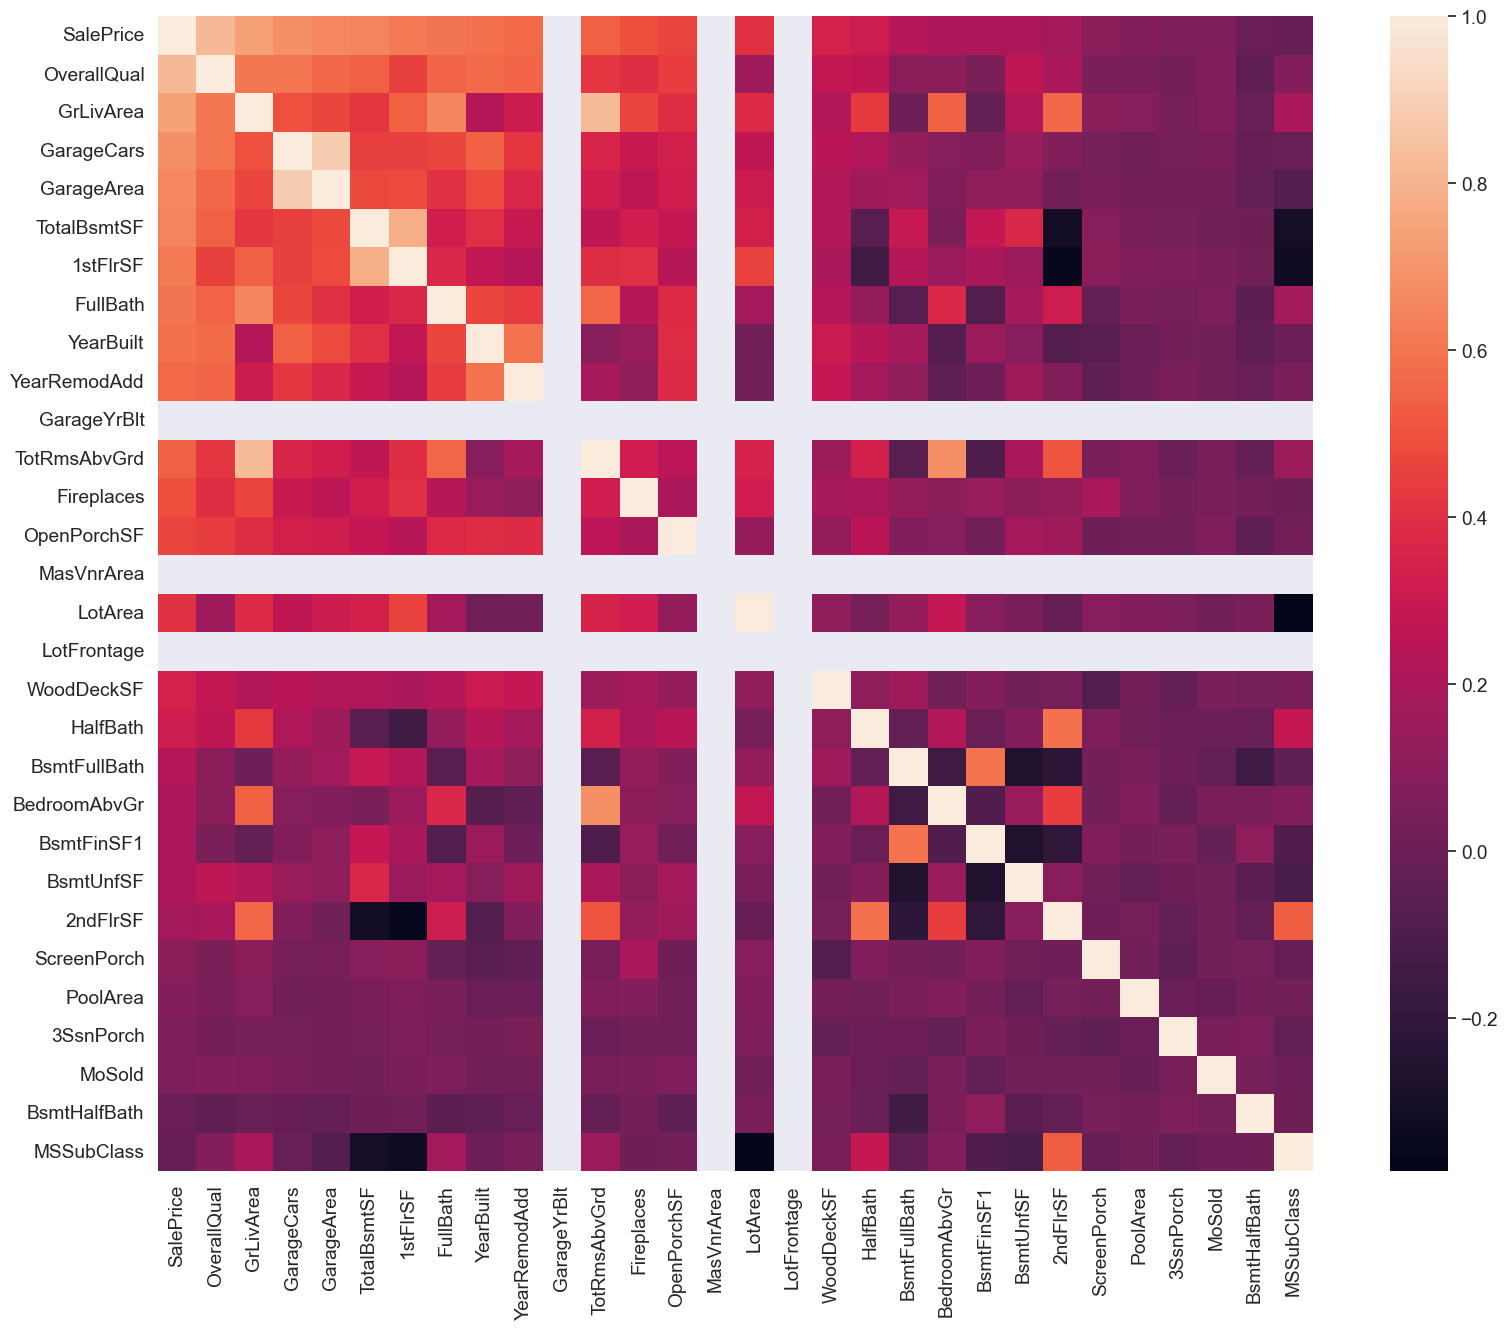

In [185]:
#saleprice correlation matrix
k = 30 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(20, 15))
hm = sns.heatmap(cm, cbar=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [140]:
# Missing Data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.996
MiscFeature,1404,0.963
Alley,1367,0.938
Fence,1177,0.807
FireplaceQu,690,0.473
LotFrontage,259,0.178
GarageYrBlt,81,0.056
GarageCond,81,0.056
GarageType,81,0.056
GarageFinish,81,0.056


In [141]:
#dealing with missing data
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() #just checking that there's no missing data missing...

C:\Users\xiaos\AppData\Local\Temp\ipykernel_5984\680243715.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)


0

In [142]:
test_total_missing = X_test.isnull().sum().sort_values(ascending=False)
test_total_missing.head(20)


PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType2      42
BsmtFinType1      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
Functional         2
dtype: int64

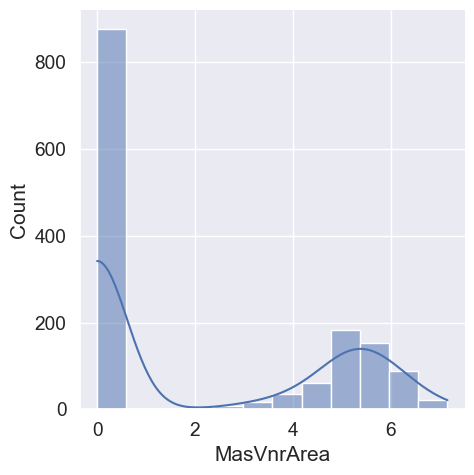

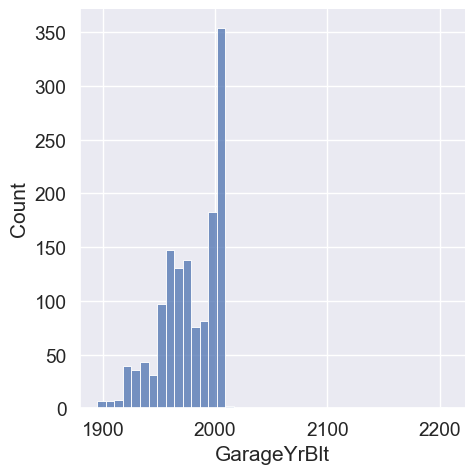

In [143]:
sns.displot(X_test['MasVnrArea'],kde=True)
sns.displot(X_test['GarageYrBlt'])

In [144]:
train.loc[:,['OverallQual','GrLivArea','TotalBsmtSF','GarageCars','1stFlrSF','GarageArea','FullBath','TotRmsAbvGrd','YearBuilt']].head()

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,1stFlrSF,GarageArea,FullBath,TotRmsAbvGrd,YearBuilt
0,7,7.445,856.000,2.000,6.753,548.000,2,8,2003
1,6,7.141,1262.000,2.000,7.141,460.000,2,6,1976
2,7,7.488,920.000,2.000,6.825,608.000,2,6,2001
3,7,7.449,756.000,3.000,6.869,642.000,1,7,1915
4,8,7.696,1145.000,3.000,7.044,836.000,2,9,2000


In [145]:
# Method 1:OLS
ols = LinearRegression(fit_intercept=True)

X_OLS = train.loc[:,['OverallQual','GrLivArea','TotalBsmtSF','GarageCars','1stFlrSF','GarageArea','FullBath','TotRmsAbvGrd','YearBuilt','Fireplaces','OpenPorchSF','LotArea','WoodDeckSF','HalfBath','BsmtFullBath']]
Y_OLS = train.loc[:,'SalePrice']

ols.fit(X_OLS,Y_OLS)

Y_OLS_pred=ols.predict(X_OLS)
r2metrics=r2_score(Y_OLS,Y_OLS_pred)
r2metrics

0.8736743299763496

In [146]:
X_OLS_test=X_test.loc[:,['OverallQual','GrLivArea','TotalBsmtSF','GarageCars','1stFlrSF','GarageArea','FullBath','TotRmsAbvGrd','YearBuilt','Fireplaces','OpenPorchSF','LotArea','WoodDeckSF','HalfBath','BsmtFullBath']]
X_OLS_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   float64
 2   TotalBsmtSF   1458 non-null   float64
 3   GarageCars    1458 non-null   float64
 4   1stFlrSF      1459 non-null   float64
 5   GarageArea    1458 non-null   float64
 6   FullBath      1459 non-null   int64  
 7   TotRmsAbvGrd  1459 non-null   int64  
 8   YearBuilt     1459 non-null   int64  
 9   Fireplaces    1459 non-null   int64  
 10  OpenPorchSF   1459 non-null   float64
 11  LotArea       1459 non-null   float64
 12  WoodDeckSF    1459 non-null   float64
 13  HalfBath      1459 non-null   int64  
 14  BsmtFullBath  1457 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 182.4 KB


In [147]:
total_test=X_OLS_test.isnull().sum().sort_values(ascending=False)
percent_test=(X_OLS_test.isnull().sum()/X_OLS_test.isnull().count()).sort_values(ascending=False)
missingdata_test=pd.concat([total_test,percent_test],axis=1,keys=['Total','Percent'])
missingdata_test.head()

,Total,Percent
BsmtFullBath,2,0.001
TotalBsmtSF,1,0.001
GarageCars,1,0.001
GarageArea,1,0.001
OverallQual,0,0.000


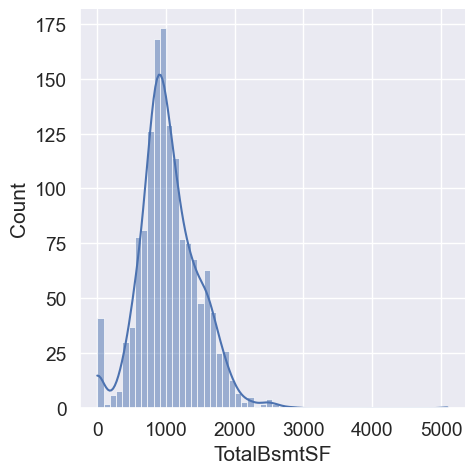

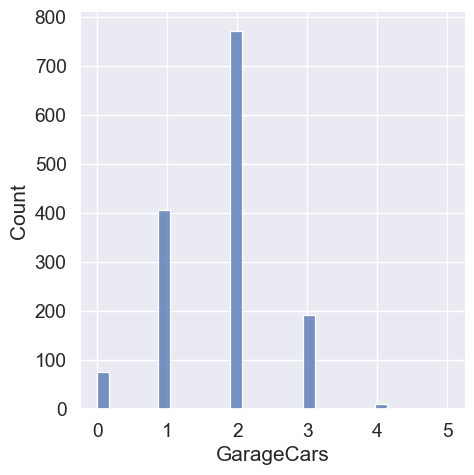

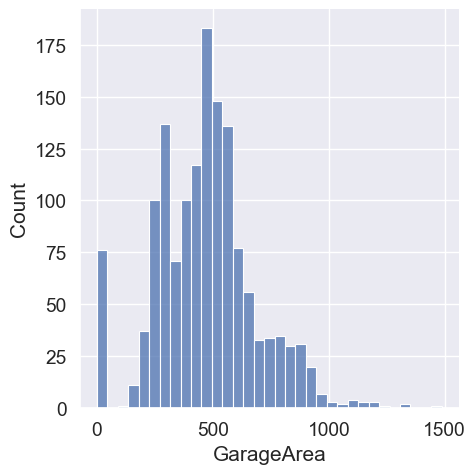

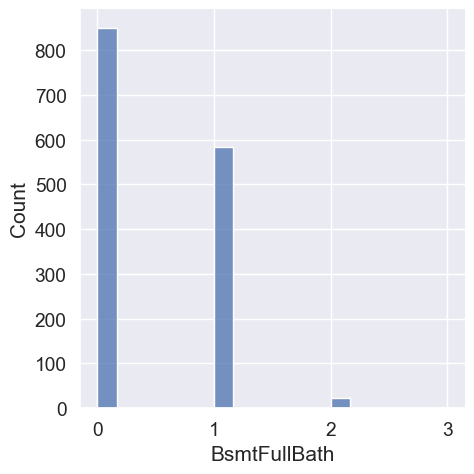

In [152]:
# Histgram for the three columns with missing data
sns.displot(X_OLS_test['TotalBsmtSF'],kde=True)
sns.displot(X_OLS_test['GarageCars'])
sns.displot(X_OLS_test['GarageArea'])
sns.displot(X_OLS_test['BsmtFullBath'])



In [153]:
# Fix missing values
X_OLS_test.loc[X_OLS_test['TotalBsmtSF'].isnull(),'TotalBsmtSF']=X_OLS_test['TotalBsmtSF'].median()
X_OLS_test.loc[X_OLS_test['GarageCars'].isnull(),'GarageCars']=2
X_OLS_test.loc[X_OLS_test['GarageArea'].isnull(),'GarageArea']=X_OLS_test['GarageArea'].median()
X_OLS_test.loc[X_OLS_test['BsmtFullBath'].isnull(),'BsmtFullBath']=0


print(X_OLS_test.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   float64
 2   TotalBsmtSF   1459 non-null   int32  
 3   GarageCars    1459 non-null   int32  
 4   1stFlrSF      1459 non-null   float64
 5   GarageArea    1459 non-null   int32  
 6   FullBath      1459 non-null   int64  
 7   TotRmsAbvGrd  1459 non-null   int64  
 8   YearBuilt     1459 non-null   int64  
 9   Fireplaces    1459 non-null   int64  
 10  OpenPorchSF   1459 non-null   float64
 11  LotArea       1459 non-null   float64
 12  WoodDeckSF    1459 non-null   float64
 13  HalfBath      1459 non-null   int64  
 14  BsmtFullBath  1459 non-null   float64
dtypes: float64(6), int32(3), int64(6)
memory usage: 165.3 KB
None


In [154]:
X_OLS_test['TotalBsmtSF']=X_OLS_test['TotalBsmtSF'].astype('int')
X_OLS_test['GarageCars']=X_OLS_test['GarageCars'].astype('int')
X_OLS_test['GarageArea']=X_OLS_test['GarageArea'].astype('int')

print(X_OLS_test.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   float64
 2   TotalBsmtSF   1459 non-null   int32  
 3   GarageCars    1459 non-null   int32  
 4   1stFlrSF      1459 non-null   float64
 5   GarageArea    1459 non-null   int32  
 6   FullBath      1459 non-null   int64  
 7   TotRmsAbvGrd  1459 non-null   int64  
 8   YearBuilt     1459 non-null   int64  
 9   Fireplaces    1459 non-null   int64  
 10  OpenPorchSF   1459 non-null   float64
 11  LotArea       1459 non-null   float64
 12  WoodDeckSF    1459 non-null   float64
 13  HalfBath      1459 non-null   int64  
 14  BsmtFullBath  1459 non-null   float64
dtypes: float64(6), int32(3), int64(6)
memory usage: 165.3 KB
None


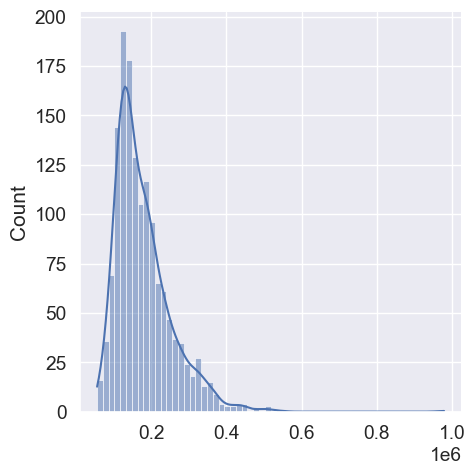

In [155]:
# Linear Model
Y_pred_test = ols.predict(X=X_OLS_test)
Y_pred_test_unlog = np.exp(Y_pred_test)
sns.displot(Y_pred_test_unlog,kde=True)

In [156]:
results=pd.concat([test['Id'],pd.Series(Y_pred_test_unlog,name='SalePrice')],axis=1)
results.to_csv('OLS_v5.csv',index=False)
